In [106]:
import pandas as pd
import numpy as np
import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
df = pd.read_json("../data/trec-medline.json", lines=True)

In [108]:
id_rows = df.iloc[::2].reset_index(drop=True)[["index"]]
id_rows["index"] = id_rows["index"].apply(lambda x: int(x["_id"]))
content_rows = df.iloc[1::2].reset_index(drop=True).drop(labels=["index"], axis=1)
combined_df = pd.concat([id_rows, content_rows], axis=1)

combined_df.head()

,index,AB,AD,CY,DA,DCOM,DP,EDAT,ID,IP,...,CON,CIN,RPF,RPI,SPIN,RIN,ROF,ORI,UOF,UIN
0,1,We present an evaluation of the accuracy and p...,Department of Molecular Biology and Skaggs Ins...,Netherlands,20011105.0,20020401.0,2001 Sep,2001/11/06 10:00,GM56879/GM/NIGMS,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,An analysis is presented of experimental versu...,"Department of Medical Biosciences, Medical Bio...",Netherlands,20011105.0,20020401.0,2001 Sep,2001/11/06 10:00,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,The global fold of maltose binding protein in ...,Protein Engineering Network Center of Excellen...,Netherlands,20011105.0,20020401.0,2001 Sep,2001/11/06 10:00,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,A general method is presented for magnetic fie...,"Molecular Structure Division, National Institu...",Netherlands,20011105.0,20020401.0,2001 Sep,2001/11/06 10:00,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,The dependence between the anomeric carbon che...,"Department of Chemistry & Biochemistry, Univer...",Netherlands,20011105.0,20020401.0,2001 Sep,2001/11/06 10:00,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
docs = combined_df[["index", "AB", "PMID"]]
docs = docs.astype({"index": int, "PMID": int})
docs.head(5)

,index,AB,PMID
0,1,We present an evaluation of the accuracy and p...,11693564
1,2,An analysis is presented of experimental versu...,11693565
2,3,The global fold of maltose binding protein in ...,11693566
3,4,A general method is presented for magnetic fie...,11693567
4,5,The dependence between the anomeric carbon che...,11693568


In [110]:
# load queries
queries = pd.DataFrame(columns=["index", "query"])

with open("../data/training-queries-simple.txt", "r") as f:
    lines = f.readlines()

data = []
for line in lines:
    x = line.strip().split("\t")
    if len(x) >= 2:  
        data.append({"index": int(x[0]), "query": x[1]})
    else:
        raise ValueError("wtf")
queries = pd.concat([queries, pd.DataFrame(data)], ignore_index=True)
queries.head(5)
print(queries.isna().sum())

index    0
query    0
dtype: int64


In [111]:
# drop missings
print(docs.isna().sum())
docs = docs.dropna()
def remove_short_strings(df, column_name):
    pattern = re.compile(r'\W+')
    filtered_df = df[df[column_name].apply(
        lambda x: isinstance(x, str) and len(pattern.sub('', x)) >= 20
    )].copy()
    filtered_df.reset_index(drop=True, inplace=True)
    
    return filtered_df
print(docs.shape[0])
docs = remove_short_strings(docs, "AB")
print(docs.shape[0])

index         0
AB       123568
PMID          0
dtype: int64
402369
401929


In [112]:
# find max words
max_words = docs['AB'].apply(lambda x: len(x.split())).max()
print(max_words)

1529


In [113]:
# load query results
query_res = pd.DataFrame(columns=["query_index", "doc_index", "relevant"])

with open("../data/training-qrels.txt", "r") as f:
    lines = f.readlines()

data = []
for line in lines:
    x = line.strip().split("\t")
    if len(x) >= 4:  
        data.append({"query_index": int(x[0]), "doc_index": int(x[2]), "relevant": int(x[3])})
    else:
        raise ValueError("wtf")
query_res = pd.concat([query_res, pd.DataFrame(data)], ignore_index=True)
print(query_res.head(5))
print(query_res.isna().sum())

  query_index doc_index relevant
0           1  11642719        1
1           1  11695244        1
2           1  11700040        1
3           1  11733969        1
4           1  11741909        1
query_index    0
doc_index      0
relevant       0
dtype: int64


In [114]:
# combine queries and results

filtered_df = query_res[query_res["relevant"] == 1]
grouped_df = filtered_df.groupby('query_index')['doc_index'].apply(list).reset_index()
grouped_df = grouped_df.rename(columns={'doc_index': 'relevant_docs'})
queries_training = pd.concat([queries, grouped_df], axis=1)
queries_training = queries_training.drop(columns=["query_index"])
queries_training.head(5)

,index,query,relevant_docs
0,1,"""cyclin-dependent kinase inhibitor 1A (p21, Ci...","[11642719, 11695244, 11700040, 11733969, 11741..."
1,2,"""DEAD/H (Asp-Glu-Ala-Asp/His) box polypeptide ...","[12101238, 12527917]"
2,3,ets variant gene 6 (TEL oncogene) in Homo sapiens,"[11731410, 11861293, 11861295, 12080468, 12091..."
3,4,fibroblast growth factor 7 (keratinocyte growt...,"[11937263, 11943656, 11973338, 12008951, 12016..."
4,5,"""glycine receptor, alpha 1 (startle disease/hy...","[11580237, 11781706, 11973623, 11981020, 11981..."


In [115]:
# inspect final datasetsts
queries_training.head(5)

,index,query,relevant_docs
0,1,"""cyclin-dependent kinase inhibitor 1A (p21, Ci...","[11642719, 11695244, 11700040, 11733969, 11741..."
1,2,"""DEAD/H (Asp-Glu-Ala-Asp/His) box polypeptide ...","[12101238, 12527917]"
2,3,ets variant gene 6 (TEL oncogene) in Homo sapiens,"[11731410, 11861293, 11861295, 12080468, 12091..."
3,4,fibroblast growth factor 7 (keratinocyte growt...,"[11937263, 11943656, 11973338, 12008951, 12016..."
4,5,"""glycine receptor, alpha 1 (startle disease/hy...","[11580237, 11781706, 11973623, 11981020, 11981..."


In [116]:
docs.head(5)

,index,AB,PMID
0,1,We present an evaluation of the accuracy and p...,11693564
1,2,An analysis is presented of experimental versu...,11693565
2,3,The global fold of maltose binding protein in ...,11693566
3,4,A general method is presented for magnetic fie...,11693567
4,5,The dependence between the anomeric carbon che...,11693568


In [117]:
# check if all doc ids from queries are in the dataset (after removing missings)
unique_relevant_docs = set(queries_training['relevant_docs'].explode())
existing_docs = unique_relevant_docs.intersection(docs.PMID)
missing_docs = unique_relevant_docs.difference(docs.PMID)

print(missing_docs)
print(f"Number of relevant docs: {len(unique_relevant_docs)}")
print(f"Number of existing docs in 'docs' DataFrame: {len(existing_docs)}")
print(f"Number of missing docs: {len(missing_docs)}")

{12147208, 12147209, 11861518, 11688978, 11822867, 11714840, 12027934, 11374883, 11406125, 11042116, 11717190, 11700040, 11781193, 11781706, 11564874, 11580237, 11882578, 11846485, 11642719, 11685227, 11466351, 11841916, 11752574, 11752575, 11779460, 11740559, 11727760, 12412576, 11686318, 11441070, 11809712, 11743158, 11701948, 11749055, 11842244, 11748297, 11733969, 11731410, 11741909, 11752172, 11751405, 12161015}
Number of relevant docs: 327
Number of existing docs in 'docs' DataFrame: 285
Number of missing docs: 42


In [118]:
# a smaller dataset
existing_docs = set(unique_relevant_docs).intersection(set(docs['PMID']))

In [119]:
# ofc there are missings relevant texts with no abstract. nice dataset:)
def filter_missing_docs(doc_list):
    return [doc for doc in doc_list if doc in existing_docs]
    
queries_training['relevant_docs'] = queries_training['relevant_docs'].apply(filter_missing_docs)
# remove quries with no docs

In [120]:
queries_training = queries_training[queries_training['relevant_docs'].apply(lambda x: len(x) > 0)]

In [121]:
queries_training = queries_training.drop(columns=["index"])
docs = docs.drop(columns=["index"])

In [122]:
def preprocess_text(text, remove_stopwords=True):
    copy = text
    copy = copy.lower()
    # remove punctuation
    copy = re.sub(r"[^\w\s]", '', copy)
    # remove double whitespaces.
    copy = re.sub(r'\s+', ' ', copy).strip()
    
    if remove_stopwords:
        copy = ' '.join(w for w in copy.split() if w not in stop_words)
    return copy

def tokenize_text(text, tokenizer):
    copy = tokenizer.tokenize(text)
    return copy

In [123]:
def precision_at_k(row, k=10):
    retrieved = row['retrieved_docs'][:k]
    relevant = set(row['relevant_docs'])
    if k == 0:
        return 0.0
    num_relevant_in_retrieved = len(set(retrieved) & relevant)
    precision = (num_relevant_in_retrieved / k) * 100
    return precision


In [124]:

def get_embeddings_words(tokens, model, tokenizer, window=512):
    window = window - 2
    embeddings = []
    for i in range(0, len(tokens), window):
        subset = tokens[i:i+window]
        subset = [tokenizer.cls_token] + subset + [tokenizer.sep_token]
        ids = tokenizer.convert_tokens_to_ids(subset)
        masks = [1] * len(ids)
        ids_tensor = torch.tensor([ids]).to(device)
        mask_tensor = torch.tensor([masks]).to(device)
        
        with torch.no_grad():
            outputs = model(ids_tensor, attention_mask=mask_tensor)
            token_embeddings = outputs[0].squeeze().cpu().numpy()
            embeddings.extend(token_embeddings)
        
    return embeddings

In [125]:
# tf-idf embedding function
def get_embeddings_words_tfidf(tokens, doc_list):
    # this function is called on a dataframe, once for each doc/query in the dataframe. tokens is a list of 
    # all the tokens in that doc/query, passed from the dataframe for each doc. doc_list does not change, so 
    # it's not changed. doc_list is a dataframe this function is called on:))))), but not row-by-row.
    # I would personally look into tf-idf and precompute idf before this function, passing the idf dataframe
    # instead in place of doc_list, as idf is the same for the entire corspus. This would prevent a lot of
    # unnecessary computations.
    # tokens = list of tokens for one doc/query
    # return matrix of embeddings = a list of vectors, where each vector - embedding of a word in a sequence.
    # vectors should be of the same dimension for all input sequences, 
    # the number of vectors in the matrix list doens't matter.
    # e.g. [[1, 2, 3], [1, 2, 3]] returned for one set of tokens and [[1, 2, 3]] for another, but
    # [[1, 2, 3], [1, 2, 3]] and [[1, 2, 3, 4], [1, 2, 3, 4]] is bad. Each token in any input sequence
    # should get a vector feature of a fixed size. See the example of returned docs.
    # when doing tf-idf, please only use token column, do not use text column.
    # to speed up computing, you can move parts of tf-idf to a separate function and set it to a variable
    # (e.g. parts which are the same, like idf).
    return [[1, 2], [1, 2], [3, 2]]

In [126]:
# try token-level
# Select the subset of the docs present in the query answers.
# no lowercasing here, as we do it ourselves.
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=False)
selected_docs = docs[docs['PMID'].isin(existing_docs)]
selected_docs_copy = selected_docs.copy(deep=True)

# preprocess and tokenize docs
print("Preprocessing docs")
selected_docs_copy["tokens"] = selected_docs_copy["AB"].progress_apply(preprocess_text)
print("Tokenizing docs")
selected_docs_copy["tokens"] = selected_docs_copy["tokens"].progress_apply(tokenize_text, tokenizer=tokenizer)

# preprocess and tokenize queries
selected_queries = queries_training.copy(deep=True)
print("Preprocessing queries")
selected_queries["tokens"] = selected_queries["query"].progress_apply(preprocess_text)
print("Tokenizing queriess")
selected_queries["tokens"] = selected_queries["tokens"].progress_apply(tokenize_text, tokenizer=tokenizer)

Preprocessing docs


100%|██████████| 285/285 [00:00<00:00, 14228.30it/s]


Tokenizing docs


100%|██████████| 285/285 [00:00<00:00, 828.94it/s]


Preprocessing queries


100%|██████████| 47/47 [00:00<?, ?it/s]


Tokenizing queriess


100%|██████████| 47/47 [00:00<00:00, 11749.45it/s]


In [127]:
# copies for tf-idf
selected_docs_tfidf = selected_docs_copy.copy(deep=True)
selected_queries_tfidf = selected_queries.copy(deep=True)

In [128]:
# calculate embedding matrices using bert
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

selected_docs_copy["embeddings"] = selected_docs_copy["tokens"].progress_apply(get_embeddings_words, model=model, tokenizer=tokenizer)
selected_queries["embedding"] = selected_queries["tokens"].progress_apply(get_embeddings_words, model=model, tokenizer=tokenizer)
selected_queries.head(2)

100%|██████████| 47/47 [00:00<00:00, 188.85it/s]


,query,relevant_docs,tokens,embedding
0,"""cyclin-dependent kinase inhibitor 1A (p21, Ci...","[11695244, 11751903, 11756412, 11762751, 11872...","[cy, ##cl, ##ind, ##ep, ##end, ##ent, kinase, ...","[[-0.7932618, -0.1177296, -0.5675259, 0.037736..."
1,"""DEAD/H (Asp-Glu-Ala-Asp/His) box polypeptide ...","[12101238, 12527917]","[dead, ##h, as, ##pg, ##lu, ##ala, ##as, ##phi...","[[-0.6105295, 0.026878148, -0.1451509, -0.0015..."


In [129]:
# calculate embedding matrices using tf-idf
selected_docs_tfidf["embeddings"] = selected_docs_tfidf["tokens"].progress_apply(
    get_embeddings_words_tfidf, doc_list=selected_docs_tfidf)
selected_queries_tfidf["embedding"] = selected_queries_tfidf["tokens"].progress_apply(
    get_embeddings_words_tfidf, doc_list=selected_docs_tfidf)
selected_queries.head(2)

100%|██████████| 47/47 [00:00<?, ?it/s]


,query,relevant_docs,tokens,embedding
0,"""cyclin-dependent kinase inhibitor 1A (p21, Ci...","[11695244, 11751903, 11756412, 11762751, 11872...","[cy, ##cl, ##ind, ##ep, ##end, ##ent, kinase, ...","[[-0.7932618, -0.1177296, -0.5675259, 0.037736..."
1,"""DEAD/H (Asp-Glu-Ala-Asp/His) box polypeptide ...","[12101238, 12527917]","[dead, ##h, as, ##pg, ##lu, ##ala, ##as, ##phi...","[[-0.6105295, 0.026878148, -0.1451509, -0.0015..."


In [130]:
def retrieve_all_docs_df(query_embeddings, dataset, top_n=10):
    # Convert query embeddings to a NumPy array
    query_embeddings = np.array(query_embeddings).astype(np.float32)

    # Extract document embeddings and PMIDs
    vectors_list = dataset["embeddings"].values
    pmids = dataset["PMID"].values.astype(np.int64)

    # Initialize a list to store similarity scores
    scores = []

    # Iterate over each document's embeddings
    for doc_emb in vectors_list:
        # Convert document embeddings to a NumPy array
        doc_emb = np.array(doc_emb).astype(np.float32)
        
        # Compute the cosine similarity matrix between query and document embeddings
        cos_sim_matrix = cosine_similarity(query_embeddings, doc_emb)
        
        # For each query embedding, find the maximum similarity with document embeddings
        max_similarities = np.max(cos_sim_matrix, axis=1)
        
        # Average the maximum similarities to get a single score for the document
        score = np.mean(max_similarities)
        scores.append(score)
    
    # Create a DataFrame with 'doc_id' and 'similarity_score' columns
    df = pd.DataFrame({
        'doc_id': pmids,
        'similarity_score': scores
    })

    # Sort the DataFrame by 'similarity_score' in descending order
    df_sorted = df.sort_values(by='similarity_score', ascending=False).reset_index(drop=True)
    top_doc_ids = df_sorted['doc_id'].head(top_n).tolist()
    
    return top_doc_ids

In [131]:
# bert base result
selected_queries["retrieved_docs"] = selected_queries["embedding"].progress_apply(retrieve_all_docs_df, 
                                                                                  dataset=selected_docs_copy)
selected_queries["precission_at_k"] = selected_queries.apply(precision_at_k, axis=1)
print(selected_queries["precission_at_k"].mean())

100%|██████████| 47/47 [00:07<00:00,  6.28it/s]

28.085106382978722


In [132]:
# tf-idf result
selected_queries_tfidf["retrieved_docs"] = selected_queries_tfidf["embedding"].progress_apply(retrieve_all_docs_df, 
                                                                                  dataset=selected_docs_tfidf)
selected_queries_tfidf["precission_at_k"] = selected_queries_tfidf.apply(precision_at_k, axis=1)
print(selected_queries_tfidf["precission_at_k"].mean())

100%|██████████| 47/47 [00:02<00:00, 21.43it/s]

2.127659574468085


In [133]:
# paired t-test
from scipy.stats import ttest_rel
from scipy import stats

bert_scores = selected_queries["precission_at_k"].to_numpy()
tfidf_scores = selected_queries_tfidf["precission_at_k"].to_numpy()

t_stat, p_two_tailed = ttest_rel(bert_scores, tfidf_scores)

p_one_tailed = stats.t.sf(t_stat, df=len(bert_scores - 1))

print(f"t-statistic: {t_stat}")
print(f"p-value (one-tailed): {p_one_tailed}")



t-statistic: 7.095797745078743
p-value (one-tailed): 2.9252322812446207e-09


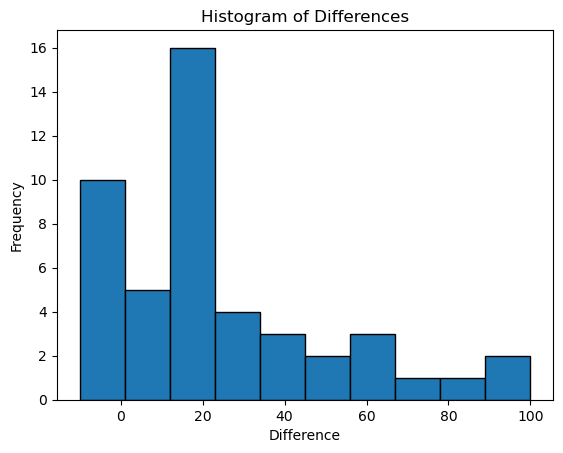

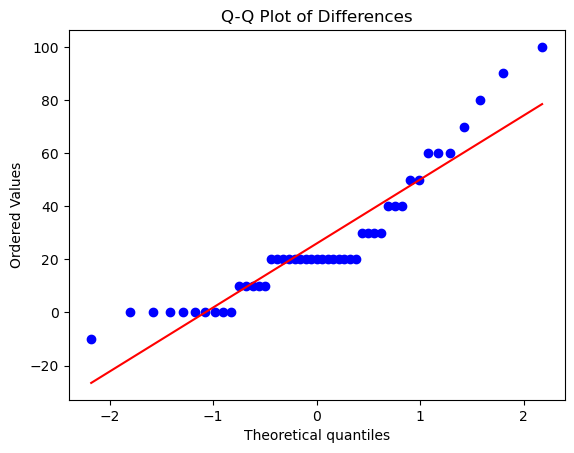

In [134]:
import matplotlib.pyplot as plt
# assessing normality
diff = np.array(bert_scores) - np.array(tfidf_scores)
plt.hist(diff, bins=10, edgecolor='black')
plt.title("Histogram of Differences")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
stats.probplot(diff, dist="norm", plot=plt)
plt.title("Q-Q Plot of Differences")
plt.show()

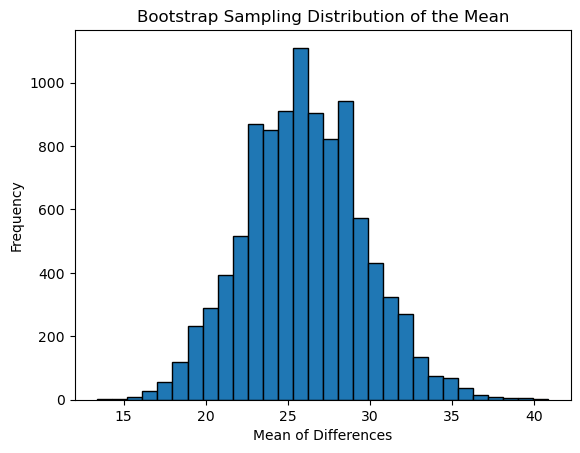

In [135]:
# bootstraping and checking for the distribution of the mean
np.random.seed(0)
n_bootstraps = 10000
bootstrap_means = []

for _ in range(n_bootstraps):
    bootstrap_sample = np.random.choice(diff, size=len(diff), replace=True)
    bootstrap_means.append(np.mean(bootstrap_sample))

plt.hist(bootstrap_means, bins=30, edgecolor='black')
plt.title("Bootstrap Sampling Distribution of the Mean")
plt.xlabel("Mean of Differences")
plt.ylabel("Frequency")
plt.show()

In [148]:
# biobert
from transformers import AutoTokenizer, AutoModel

bio_bert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

In [149]:
bio_docs = selected_docs.copy(deep=True)

# preprocess and tokenize docs
print("Preprocessing docs")
bio_docs["tokens"] = bio_docs["AB"].progress_apply(preprocess_text)
print("Tokenizing docs")
bio_docs["tokens"] = bio_docs["tokens"].progress_apply(tokenize_text, tokenizer=bio_bert_tokenizer)

# preprocess and tokenize queries
bio_queries = queries_training.copy(deep=True)
print("Preprocessing queries")
bio_queries["tokens"] = bio_queries["query"].progress_apply(preprocess_text)
print("Tokenizing queriess")
bio_queries["tokens"] = bio_queries["tokens"].progress_apply(tokenize_text, tokenizer=bio_bert_tokenizer)


Preprocessing docs


100%|██████████| 285/285 [00:00<00:00, 13701.69it/s]


Tokenizing docs


100%|██████████| 285/285 [00:00<00:00, 3480.19it/s]


Preprocessing queries


100%|██████████| 47/47 [00:00<00:00, 45738.35it/s]


Tokenizing queriess


100%|██████████| 47/47 [00:00<00:00, 23507.31it/s]


In [152]:
# biobert embeddings and results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bio_bert_model.to(device)
bio_docs["embeddings"] = bio_docs["tokens"].progress_apply(get_embeddings_words, 
                                                           model=bio_bert_model, tokenizer=bio_bert_tokenizer)
bio_queries["embedding"] = bio_queries["tokens"].progress_apply(get_embeddings_words, 
                                                                model=bio_bert_model, tokenizer=bio_bert_tokenizer)
bio_queries.head(2)

100%|██████████| 47/47 [00:00<00:00, 189.45it/s]


,query,relevant_docs,tokens,embedding
0,"""cyclin-dependent kinase inhibitor 1A (p21, Ci...","[11695244, 11751903, 11756412, 11762751, 11872...","[c, ##y, ##c, ##lind, ##ep, ##end, ##ent, kina...","[[0.20086853, -0.14764602, -0.37700272, 0.2681..."
1,"""DEAD/H (Asp-Glu-Ala-Asp/His) box polypeptide ...","[12101238, 12527917]","[dead, ##h, as, ##p, ##g, ##lu, ##ala, ##as, #...","[[0.2857882, -0.042199947, -0.29392847, 0.0733..."


In [153]:
bio_queries["retrieved_docs"] = bio_queries["embedding"].progress_apply(retrieve_all_docs_df, 
                                                                                  dataset=bio_docs)
bio_queries["precission_at_k"] = bio_queries.apply(precision_at_k, axis=1)
print(bio_queries["precission_at_k"].mean())

100%|██████████| 47/47 [00:08<00:00,  5.76it/s]

29.574468085106382


In [ ]:
# test between bert and biobert
from scipy.stats import ttest_rel
from scipy import stats

bert_scores = selected_queries["precission_at_k"].to_numpy()
bio_bert_scores = bio_queries["precission_at_k"].to_numpy()

t_stat, p_two_tailed = ttest_rel(bio_bert_scores, bert_scores)

p_one_tailed = stats.t.sf(t_stat, df=len(bio_bert_scores - 1))

print(f"t-statistic: {t_stat}")
print(f"p-value (one-tailed): {p_one_tailed}")